# Get the vibe - Experimental Notebook

## Set up

### Imports

In [1]:
# General libraries
import numpy as np
import pandas as pd

# Image related
import matplotlib.pyplot as plt 
from matplotlib import image
from keras.preprocessing.image import load_img, img_to_array
import os

# CNN
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping

# Confusion Matrix & Additional Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

#### Set up

In [2]:
!pwd

/Users/jasperanger/code/JaildoR/getthevibe_api/notebooks


In [3]:
# Import Data 
image_df = pd.read_csv("../getthevibe_api/data/fer2013.csv")

In [4]:
# Data Path
# folder_path = "../../JaildoR/getthevibe_api/getthevibe_api/data/fer2013.csv"

In [5]:
# Define Emotions
Emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]  # indices 0 to 6

In [6]:
# Insert column emotions
image_df["emotion_new"] = image_df["emotion"].map({0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"})

### Display Images

In [7]:
# Define formate
FER2013_WIDTH = 48
FER2013_HEIGHT = 48

In [8]:
# Function showing picture
def show_image(index):
    """Shows the image and the emotion label of the index's instance."""
    image = image_data.at[index, "pixels"].split(" ")
    image = np.reshape(image,(FER2013_WIDTH, FER2013_HEIGHT)).astype("float")
    print(Emotions[image_data.at[index, "emotion"]])
    plt.imshow(image)

###  Simple Descriptives

In [9]:
image_df.describe

<bound method NDFrame.describe of        emotion                                             pixels  \
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...   
1            0  151 150 147 155 148 133 111 140 170 174 182 15...   
2            2  231 212 156 164 174 138 161 173 182 200 106 38...   
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...   
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...   
...        ...                                                ...   
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...   
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...   
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...   
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...   
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...   

             Usage emotion_new  
0         Training       Angry  
1         Training       Angry  
2         Training        Fear  
3    

In [10]:
# Shape
image_df.shape

(35887, 4)

In [11]:
# Pixels per picture
exp_pixel = image_df.iloc[0]['pixels']
len(exp_pixel.split())

2304

In [12]:
# Format 
2304**0.5

48.0

In [13]:
# Check zeros
image_df.isnull().sum()

emotion        0
pixels         0
Usage          0
emotion_new    0
dtype: int64

### Advances Descriptives

#### Categories 

In [14]:
# Show emotional categories
cat_data = image_df["emotion"].value_counts().sort_index()
cat_data

0    4953
1     547
2    5121
3    8989
4    6077
5    4002
6    6198
Name: emotion, dtype: int64

In [15]:
cat_data = image_df["emotion_new"].count()
cat_data

35887

<BarContainer object of 35887 artists>

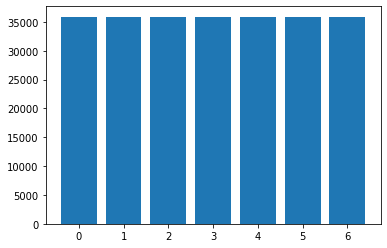

In [16]:
# Graph categories
x_axis = image_df["emotion"]
y_axis = cat_data
plt.bar(x_axis, y_axis)

## Preprosessing

### Training Data Split

In [17]:
train_set = image_df[(image_df.Usage == 'Training')] 
val_set = image_df[(image_df.Usage == 'PublicTest')]
test_set = image_df[(image_df.Usage == 'PrivateTest')] 

### Reshape X

In [18]:
# define x
X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_val = np.array(list(map(str.split, val_set.pixels)), np.float32) 
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32) 


X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

### Scaling 

In [19]:
X_train = (X_train/255) -0.5
X_val = (X_val/255) - 0.5
X_test = (X_test/255) - 0.5

### One hot encode y

In [20]:
# define y
y_train = train_set["emotion"]
y_val = val_set["emotion"]
y_test = test_set["emotion"]

In [21]:
y_test

32298    0
32299    5
32300    6
32301    4
32302    2
        ..
35882    6
35883    3
35884    0
35885    3
35886    2
Name: emotion, Length: 3589, dtype: int64

In [22]:
# One Hot Encode our Target for TensorFlow processing
from tensorflow.keras.utils import to_categorical

y_cat_train = to_categorical(y_train, num_classes=7)
y_cat_test = to_categorical(y_test, num_classes=7)
y_cat_val = to_categorical(y_val, num_classes=7)

## Model

#### Notes on CNN

Notes on CNN: 
- the kernel size decreases
- the number of filters increases (compared to the previous layers)

- channels = depth of an image
- filters = operation on an image
    - has many kernels
    - with padding
    - with strides
- pooling layers reduces image size

### Baseline Model

#### Baseline Model Application

Differences to stupid mode: padding, more kernels, extra layer, more filters, with strides, with pooling

In [23]:
### 1. Architecture
model_bl = models.Sequential()

model_bl.add(layers.Conv2D(filters = 16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)))
model_bl.add(layers.MaxPool2D(pool_size=(3,3))) 

model_bl.add(layers.Conv2D(32, kernel_size=(2,2), strides=(2,2), activation='relu')) 
model_bl.add(layers.MaxPool2D(pool_size=(2,2))) 

model_bl.add(layers.Conv2D(32, kernel_size=(2,2), activation='relu')) 
model_bl.add(layers.MaxPool2D(pool_size=(2,2))) 

model_bl.add(layers.Flatten())
model_bl.add(layers.Dense(7, activation='softmax')) 

model_bl.summary()

2022-03-08 11:05:23.031966: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 32)          4128      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 32)         0

In [24]:
#### 2. Compilation
model_bl.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
#### 3. Fit
es = EarlyStopping(patience=5)

history_bl = model_bl.fit(X_train, y_cat_train,
                    epochs=5,
                    batch_size=32, 
                    verbose=1,
                    validation_data=(X_val,y_cat_val),
                    callbacks=[es]) 

Epoch 1/5
898/898 [==============================] - 15s 16ms/step - loss: 1.7850 - accuracy: 0.2565 - val_loss: 1.7722 - val_accuracy: 0.2563
Epoch 2/5
898/898 [==============================] - 15s 17ms/step - loss: 1.7471 - accuracy: 0.2839 - val_loss: 1.7164 - val_accuracy: 0.3146
Epoch 3/5
898/898 [==============================] - 19s 22ms/step - loss: 1.6815 - accuracy: 0.3243 - val_loss: 1.6605 - val_accuracy: 0.3522
Epoch 4/5
898/898 [==============================] - 19s 22ms/step - loss: 1.6241 - accuracy: 0.3601 - val_loss: 1.6066 - val_accuracy: 0.3725
Epoch 5/5
898/898 [==============================] - 20s 22ms/step - loss: 1.5839 - accuracy: 0.3822 - val_loss: 1.5802 - val_accuracy: 0.3784


#### Baseline Model Evaluation

In [26]:
np.array(history_bl.history["val_accuracy"])

array([0.2563388 , 0.3145723 , 0.35218725, 0.37252715, 0.37837839])

In [27]:
# Evaluate model on the test data
print(model_bl.evaluate(X_test, y_cat_test, verbose=0))

[1.5919063091278076, 0.3822791874408722]


In [28]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_title('Accurary')
    ax2.legend()
    return (ax1, ax2)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accurary'}>)

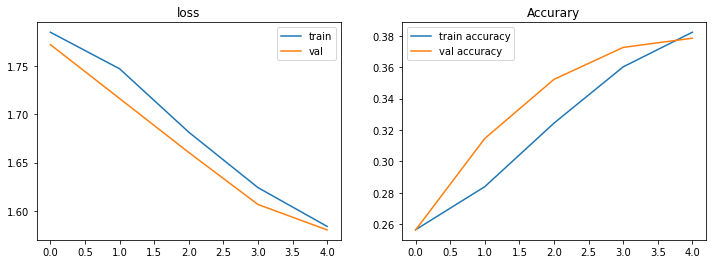

In [29]:
plot_history(history_bl)

## Confusion Matrix & Additional Metrics 

### Confusion Matrix

/var/folders/jk/sqv2vrvx1819g_xv6zn3w3vw0000gn/T/ipykernel_95633/2238632869.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm / cm.astype(np.float).sum(axis=1) # convert into percentages


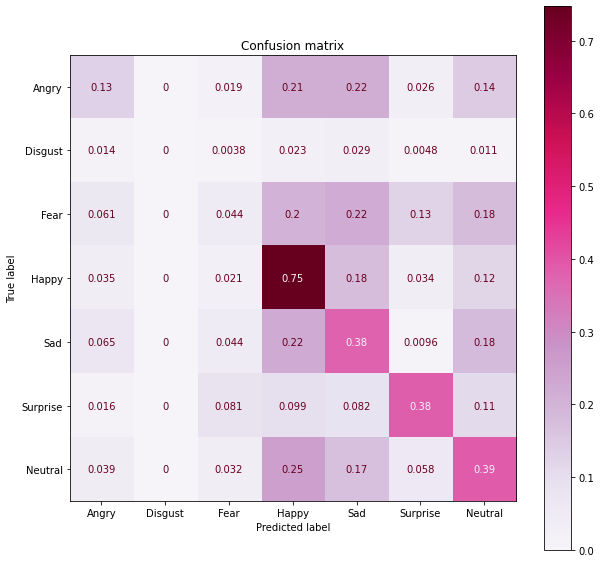

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute probabilities of belonging to one of the classes
predicted_probabilities = model_bl.predict(X_test)
def prediction_from_probabilities(predicted_probabilities):
    return np.argmax(predicted_probabilities)
y_pred = np.apply_along_axis(prediction_from_probabilities, 
                             1,                            
                             predicted_probabilities)  

# Compute the Confusion Matrix
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.astype(np.float).sum(axis=1) # convert into percentages
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = labels);
fig, ax = plt.subplots(figsize=(10,10));
title='Confusion matrix'
plt.title(title)
disp.plot(cmap = "PuRd", ax = ax);

### Additional Metrics

In [56]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

       Angry       0.36      0.13      0.19       491
     Disgust       0.00      0.00      0.00        55
        Fear       0.18      0.04      0.07       528
       Happy       0.42      0.75      0.54       879
         Sad       0.30      0.38      0.33       594
    Surprise       0.60      0.38      0.47       416
     Neutral       0.34      0.39      0.36       626

    accuracy                           0.38      3589
   macro avg       0.31      0.30      0.28      3589
weighted avg       0.36      0.38      0.34      3589



/Users/jasperanger/.pyenv/versions/3.8.12/envs/getthevibe_api/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jasperanger/.pyenv/versions/3.8.12/envs/getthevibe_api/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jasperanger/.pyenv/versions/3.8.12/envs/getthevibe_api/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param